This is the notebook to build the data processing pipeline to feed into the GRU network. It starts with a slimmed and skimmed csv file with p2_calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

All data is in its original units.

Also, I'm running this in the Python 3.7.1 Kernel

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker

In [45]:
#load the data
df = pd.read_csv('../scripts/slimmed_df.csv')
#there are many times when the xtal is not fired upon. This means the laser_datetime is NaN, 
#and importantly, the lumi columns: int_deliv_inv_ub and int_record_inv_ub give an erroneous value.
print(df.shape)
df_laser_dropped = df.dropna(subset=['laser_datetime'])
print(df_laser_dropped.shape)

(92170, 22)
(77380, 22)


In [46]:
df_laser_dropped.head()

,Unnamed: 0,Unnamed: 1,iov_idx,seq_datetime,calibration,inst_lumi,laser_datetime,int_inst_lumi,p1,p2,...,#run:fill,ls,beamstatus,E(GeV),delivered(/ub),recorded(/ub),avgpu,source,int_deliv_inv_ub,int_record_inv_ub
0,54000,0,0,2018-02-07 16:14:44,0.937300,NaN,2018-02-07 16:15:53,0.0,0.937300,0.937300,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0
1,54000,1,1,2018-02-07 17:26:08,0.937845,NaN,2018-02-07 17:28:57,0.0,0.937824,0.937845,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0
2,54000,2,2,2018-02-07 17:50:56,0.936282,NaN,2018-02-07 17:53:45,0.0,0.936460,0.936282,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0
3,54000,3,3,2018-02-07 18:15:44,0.936760,NaN,2018-02-07 18:18:33,0.0,0.936706,0.936760,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0
4,54000,4,4,2018-02-07 18:57:17,0.937384,NaN,2018-02-07 19:00:07,0.0,0.937342,0.937384,...,314090:6545,67:0,FLAT TOP,6500,0.052346,0.0,0.0,BCM1F,0.052346,0.0


In [47]:
#the data has multiple possible indices. The most important, is to split the data based on the crystal index which is called Unnamed: 0 at the moment.
df_laser_dropped = df_laser_dropped.rename(columns={'Unnamed: 0':'xtal_idx', 'Unnamed: 1':'dst_idx'})
xtal_groups = df.groupby(df_laser_dropped.xtal_idx)
xtal_list = df_laser_dropped.xtal_idx.unique()


In [54]:
df_54000 = xtal_groups.get_group(54000)
#now we'll select just the columns we want to study
df_slim = df_54000.loc[:,['laser_datetime','p2','int_deliv_inv_ub']]
#set the index to the sequence start time
df_slim['laser_datetime'] = df_slim['laser_datetime'].astype('datetime64')
df_slim.set_index('laser_datetime', inplace=True)
df_slim.head()

,p2,int_deliv_inv_ub
laser_datetime,,
2018-02-07 16:15:53,0.937300,0.052346
2018-02-07 17:28:57,0.937845,0.052346
2018-02-07 17:53:45,0.936282,0.052346
2018-02-07 18:18:33,0.936760,0.052346
2018-02-07 19:00:07,0.937384,0.052346


In [55]:
#split the data into training, testing and validating
#select the data range (we'll select the part of the year when the beam was operating)
data_begin = '2018-05-12 08:00:00'
data_end = '2018-12-02 16:00:00'

df_select = df_slim[(df_slim.index > data_begin) & (df_slim.index < data_end)]
df_select.to_csv('../data/select.csv')
#select the time ranges for train,valid,test datasets
df_train_end = '2018-08-31 00:00:00'
df_valid_end = '2018-10-15 00:00:00'
df_test_end = data_end

df_train = df_select[df_select.index < df_train_end]
df_valid = df_select[(df_select.index < df_valid_end) & (df_select.index > df_train_end)]
df_test = df_select[(df_select.index < df_test_end) & (df_select.index > df_valid_end)]

/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


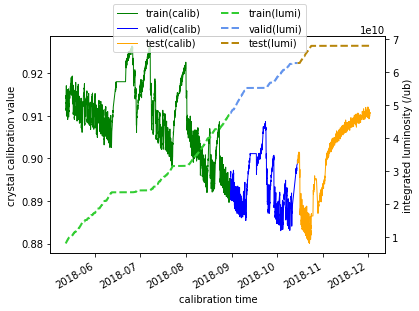

In [56]:
#now lets make a plot of our three datasets

fig, ax1 = plt.subplots()

ax1.set_ylabel('crystal calibration value')
ax1.set_xlabel('calibration time')
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax1.plot(df_train.index, df_train.p2, 
         label='train(calib)', color='green', linewidth=1, linestyle='solid')
ax1.plot(df_valid.index, df_valid.p2, 
         label='valid(calib)', color='blue', linewidth=1, linestyle='solid')
ax1.plot(df_test.index, df_test.p2, 
         label='test(calib)', color='orange', linewidth=1, linestyle='solid')

#lumi data on alternate y axis
ax2 = ax1.twinx()
ax2.set_ylabel('integrated luminosity (/ub)')

ax2.plot(df_train.index, df_train.int_deliv_inv_ub, 
         label='train(lumi)', color='limegreen', linewidth=2, linestyle='dashed')
ax2.plot(df_valid.index, df_valid.int_deliv_inv_ub, 
         label='valid(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed')
ax2.plot(df_test.index, df_test.int_deliv_inv_ub, 
         label='test(lumi)', color='darkgoldenrod', linewidth=2, linestyle='dashed')
#combined legend
fig.legend(ncol=2, loc = 'upper center')

fig.show()

In [57]:
#lets look at the time spacing in the raw data
calib_timedelta = df_select.reset_index().laser_datetime.diff()
calib_td_mins = calib_timedelta.apply(lambda x: x.seconds/60)

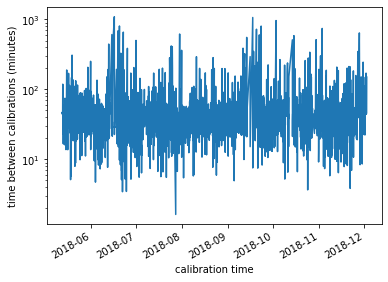

In [58]:
fig8, ax12 = plt.subplots()

ax12.set_ylabel('time between calibrations (minutes)')
ax12.set_xlabel('calibration time')
plt.setp(ax12.get_xticklabels(), rotation=30, horizontalalignment='right')
ax12.set_yscale('log')

ax12.plot(df_select.index, calib_td_mins, label='calib_td')
fig8.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


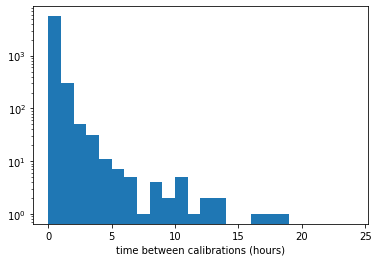

In [59]:
fig9, ax13 = plt.subplots()

calib_td_hrs = calib_timedelta.apply(lambda x: x.seconds/3600)
bins = [bin for bin in range(0, 24+1, 1)]
print(bins)
ax13.hist(calib_td_hrs, bins=bins)
ax13.set_xlabel('time between calibrations (hours)')
plt.setp(ax12.get_xticklabels(), rotation=30, horizontalalignment='right')
ax13.set_yscale('log')

fig9.show()

0         NaN
1    0.748889
2    0.751111
3    0.750000
4    0.789722
Name: laser_datetime, dtype: float64


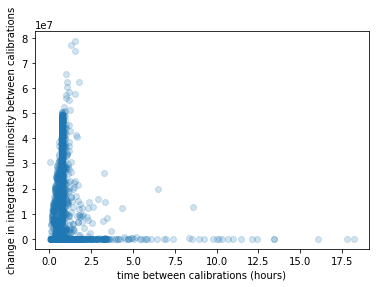

In [60]:
#lets look at the correlation between time delta and the change in integrated luminosity over the period
lumi_delta = df_select.int_deliv_inv_ub.diff()
print(calib_td_hrs.head())
fig, ax = plt.subplots()
ax.set_xlabel('time between calibrations (hours)')
ax.set_ylabel('change in integrated luminosity between calibrations')

ax.scatter(calib_td_hrs, lumi_delta, alpha='0.2')
fig.show()

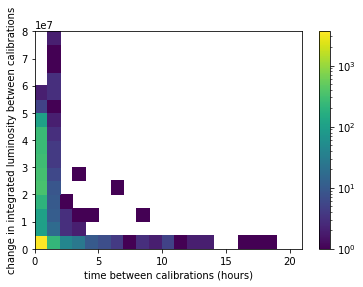

In [61]:
fig, ax = plt.subplots()
import matplotlib.colors as clrs
ax.set_xlabel('time between calibrations (hours)')
ax.set_ylabel('change in integrated luminosity between calibrations')

h = ax.hist2d(calib_td_hrs, lumi_delta, bins=[21, 16], range=[[0.0, 21.0], [0.0, 8e7]], norm=clrs.LogNorm())
fig.colorbar(h[3], ax=ax)
fig.show()

In [67]:
#now that we've looked at the raw data, we have to do a few manipulations.
#the first is to convert the data into an evenly spaced timeseries. We'll use a rolling average
import traces as ts

sampling=3600
avg_window = sampling*6
#windows are in seconds
train_calib_avg = ts.TimeSeries(df_train['p2'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
train_lumi_avg = ts.TimeSeries(df_train['int_deliv_inv_ub'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

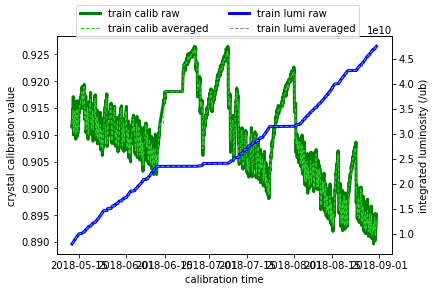

In [68]:
#lets plot the situation
fig2, ax3 = plt.subplots()

ax3.set_ylabel('crystal calibration value')
ax3.set_xlabel('calibration time')

#calibration data
ax3.plot(df_train.index, df_train.p2, 
         label='train calib raw', color='green', linewidth=3, linestyle='solid')
ax3.plot(train_calib_avg.index, train_calib_avg, 
         label='train calib averaged', color='limegreen', linewidth=1, linestyle='dashed')

#lumi data on alternate y axis
ax4 = ax3.twinx()
ax4.set_ylabel('integrated luminosity (/ub)')

ax4.plot(df_train.index, df_train.int_deliv_inv_ub, 
         label='train lumi raw', color='blue', linewidth=3, linestyle='solid')
ax4.plot(train_lumi_avg.index, train_lumi_avg, 
         label='train lumi averaged', color='cornflowerblue', linewidth=1, linestyle='dashed')

#combined legend
fig2.legend(ncol=2, loc = 'upper center')

fig2.show()

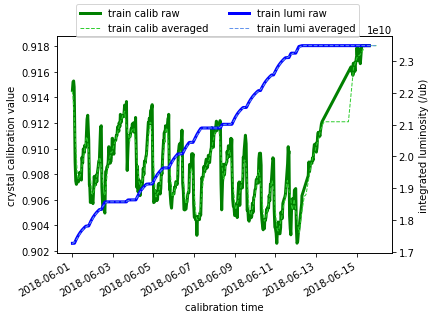

In [69]:
#lets plot a zoomed in view of the situation
fig3, ax5 = plt.subplots()

ax5.set_ylabel('crystal calibration value')
ax5.set_xlabel('calibration time')
plt.setp(ax5.get_xticklabels(), rotation=30, horizontalalignment='right')

max_time = '2018-06-16 00:00:00'
min_time = '2018-06-01 00:00:00'

df_zoom = df_train[(df_train.index < max_time) & (df_train.index > min_time)]
train_calib_avg_zoom = train_calib_avg[(train_calib_avg.index < max_time) & (train_calib_avg.index > min_time)]
train_lumi_avg_zoom = train_lumi_avg[(train_lumi_avg.index < max_time) & (train_lumi_avg.index > min_time)]

#calibration data
ax5.plot(df_zoom.index, df_zoom.p2, 
         label='train calib raw', color='green', linewidth=3, linestyle='solid')
ax5.plot(train_calib_avg_zoom.index, train_calib_avg_zoom, 
         label='train calib averaged', color='limegreen', linewidth=1, linestyle='dashed')

#lumi data on alternate y axis
ax6 = ax5.twinx()
ax6.set_ylabel('integrated luminosity (/ub)')

ax6.plot(df_zoom.index, df_zoom.int_deliv_inv_ub, 
         label='train lumi raw', color='blue', linewidth=3, linestyle='solid')
ax6.plot(train_lumi_avg_zoom.index, train_lumi_avg_zoom, 
         label='train lumi averaged', color='cornflowerblue', linewidth=1, linestyle='dashed')


#combined legend
fig3.legend(ncol=2, loc = 'upper center')

fig3.show()
#you can see that it isn't perfect when there are gaps in the data.
#this can be tweaked by increasing the sliding average size, but then you lose resolution
#figuring out how to run it with a variable resolution would be tricky.
#but you could also choose a different interpolation technique to try to paste over the gaps

In [72]:
#now that we've explored the interpolation and made interpolated training data,
#we'll follow the same steps for the testing and validation data
valid_calib_avg = ts.TimeSeries(df_valid['p2'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
valid_lumi_avg = ts.TimeSeries(df_valid['int_deliv_inv_ub'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

test_calib_avg = ts.TimeSeries(df_test['p2'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)
test_lumi_avg = ts.TimeSeries(df_test['int_deliv_inv_ub'])\
                                .moving_average(sampling, window_size=avg_window, pandas=True)

#now we'll put it all back into dataframes
train = pd.DataFrame()
train['p2'] = train_calib_avg
train['int_deliv_inv_ub'] = train_lumi_avg
train.to_csv('../data/train_avg.csv')

valid = pd.DataFrame()
valid['p2'] = valid_calib_avg
valid['int_deliv_inv_ub'] = valid_lumi_avg
valid.to_csv('../data/valid_avg.csv')

test = pd.DataFrame()
test['p2'] = test_calib_avg
test['int_deliv_inv_ub'] = test_lumi_avg
test.to_csv('../data/test_avg.csv')

In [73]:
#now we need to de-trend the data so that it is flat over time
#for this I'll just apply differencing, since it is pretty simple
train = train.diff().dropna() #we run dropna, since the first row is NaN in a diff
valid = valid.diff().dropna()
test = test.diff().dropna()

train.to_csv('../data/train_diff.csv')
valid.to_csv('../data/valid_diff.csv')
test.to_csv('../data/test_diff.csv')

In [74]:
#now we'll scale the input data for the network
#scale values to between 0 and 1
#for the lumi data, there are many orders of magnitude within the lumi, we want to transform the lumi data to truncate very small values, and convert to log for higher orders of magnitude. and then we'll minmax scale it
train['int_deliv_inv_ub'], train_floor = scale_shrinker(train['int_deliv_inv_ub'], 3, True, True) #set the floor at 10^-3 of the max, take the log_10
valid['int_deliv_inv_ub'], _ = scale_shrinker(valid['int_deliv_inv_ub'], train_floor, True, False) #set the floor at train_floor, take the log_10
test['int_deliv_inv_ub'], _ = scale_shrinker(test['int_deliv_inv_ub'], train_floor, True, False)

scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler() #we'll use the y-scaler later
y_scaler.fit(train[['p2']])
train[['p2', 'int_deliv_inv_ub']] = scaler.fit_transform(train)
valid[['p2', 'int_deliv_inv_ub']] = scaler.transform(valid)
test[['p2', 'int_deliv_inv_ub']] = scaler.transform(test)

/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


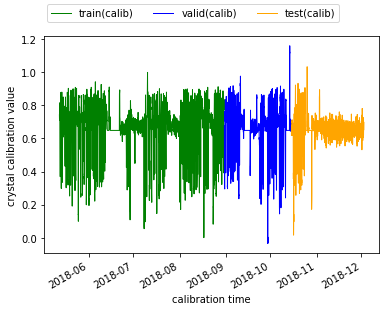

In [75]:
#lets plot the data 1 more time
fig4, ax7 = plt.subplots()

ax7.set_ylabel('crystal calibration value')
ax7.set_xlabel('calibration time')
plt.setp(ax7.get_xticklabels(), rotation=30, horizontalalignment='right')

#calibration data
ax7.plot(train.index, train.p2, 
         label='train(calib)', color='green', linewidth=1, linestyle='solid')
ax7.plot(valid.index, valid.p2, 
         label='valid(calib)', color='blue', linewidth=1, linestyle='solid')
ax7.plot(test.index, test.p2, 
         label='test(calib)', color='orange', linewidth=1, linestyle='solid')
#legend
fig4.legend(ncol=3, loc = 'upper center')
fig4.show()

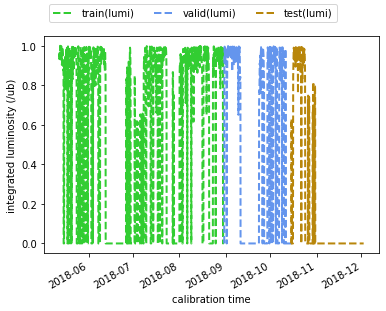

In [76]:
#lumi data on alternate y axis
fig5, ax8 = plt.subplots()
ax8.set_ylabel('integrated luminosity (/ub)')
ax8.set_xlabel('calibration time')
plt.setp(ax8.get_xticklabels(), rotation=30, horizontalalignment='right')

ax8.plot(train.index, train.int_deliv_inv_ub, 
         label='train(lumi)', color='limegreen', linewidth=2, linestyle='dashed')
ax8.plot(valid.index, valid.int_deliv_inv_ub, 
         label='valid(lumi)', color='cornflowerblue', linewidth=2, linestyle='dashed')
ax8.plot(test.index, test.int_deliv_inv_ub, 
         label='test(lumi)', color='darkgoldenrod', linewidth=2, linestyle='dashed')
#legend
fig5.legend(ncol=3, loc = 'upper center')
fig5.show()

In [77]:
#now we'll save the data
train.to_csv('../data/train_final.csv')
test.to_csv('../data/test_final.csv')
valid.to_csv('../data/valid_final.csv')
full = train.append([valid,test])
full.to_csv('../data/full_final.csv')